2025-04-24 18:38:02.717168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745519882.883385      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745519882.934387      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda:0
Dataset loaded with shape: (25600, 11)

=== Dataset Analysis ===
Dataset shape: (25600, 11)
Column names: ['ids', 'name', 'text', 'label', 'id', 'gender', 'age', 'age_bucket', 'dominant_emotion', 'dominant_race', 'translated_text']

Label distribution:
label
1    17388
0     8212
Name: count, dtype: int64

Sample translated_text entries:
1: Amma: HSC It's coming , from now on and , I'll kill all your   Me: mobile laptops          ...
2: WHEN YOUR COUSINS TAKES YOU TO THE DHAN KHET AND SHOWS HIS KALO BONDUK...
3: WHEN HE SAID 10 MINUTES BUT IT WAS ONLY 2 MINUTES...
4: SHE - I CAN'T BE WITH YOU   - I want you to ...
5: When you Teacher say   "tell the truth, then don't say anything"  brother, what a fool's got in my ?...

Missing values by column:
ids                     0
name                    0
text                  285
label                   0
id                  18554
gender              18554
age                 18554
age_bucket          18554
dominant_emotio

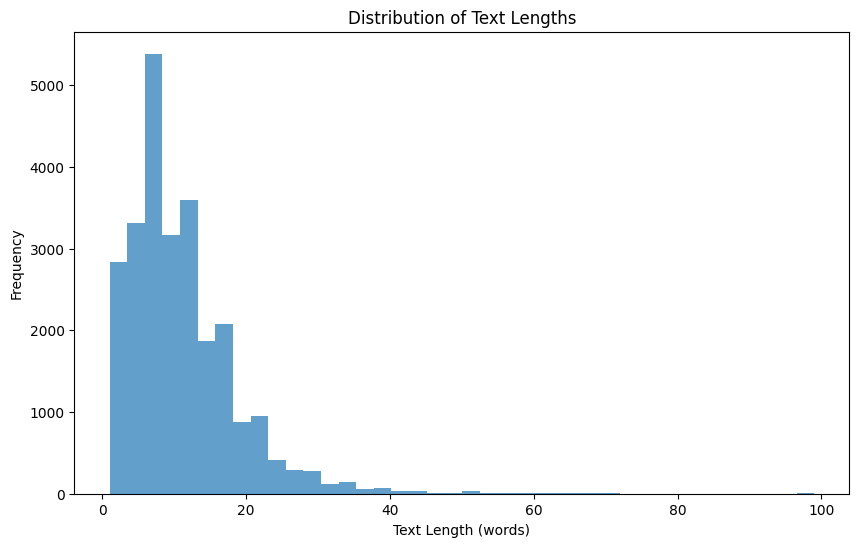

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

Train set: 17920, Validation set: 3840, Test set: 3840


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Starting training...
Epoch 1, Batch 10/560, Loss: 0.3043
Epoch 1, Batch 20/560, Loss: 0.2352
Epoch 1, Batch 30/560, Loss: 0.3354
Epoch 1, Batch 40/560, Loss: 0.3247
Epoch 1, Batch 50/560, Loss: 0.1858
Epoch 1, Batch 60/560, Loss: 0.3496
Epoch 1, Batch 70/560, Loss: 0.2447
Epoch 1, Batch 80/560, Loss: 0.2893
Epoch 1, Batch 90/560, Loss: 0.3596
Epoch 1, Batch 100/560, Loss: 0.2727
Epoch 1, Batch 110/560, Loss: 0.2693
Epoch 1, Batch 120/560, Loss: 0.3230
Epoch 1, Batch 130/560, Loss: 0.3794
Epoch 1, Batch 140/560, Loss: 0.2723
Epoch 1, Batch 150/560, Loss: 0.2771
Epoch 1, Batch 160/560, Loss: 0.2513
Epoch 1, Batch 170/560, Loss: 0.2773
Epoch 1, Batch 180/560, Loss: 0.2772
Epoch 1, Batch 190/560, Loss: 0.2871
Epoch 1, Batch 200/560, Loss: 0.3396
Epoch 1, Batch 210/560, Loss: 0.3129
Epoch 1, Batch 220/560, Loss: 0.2725
Epoch 1, Batch 230/560, Loss: 0.2530
Epoch 1, Batch 240/560, Loss: 0.3195
Epoch 1, Batch 250/560, Loss: 0.2302
Epoch 1, Batch 260/560, Loss: 0.2536
Epoch 1, Batch 270/560, Lo

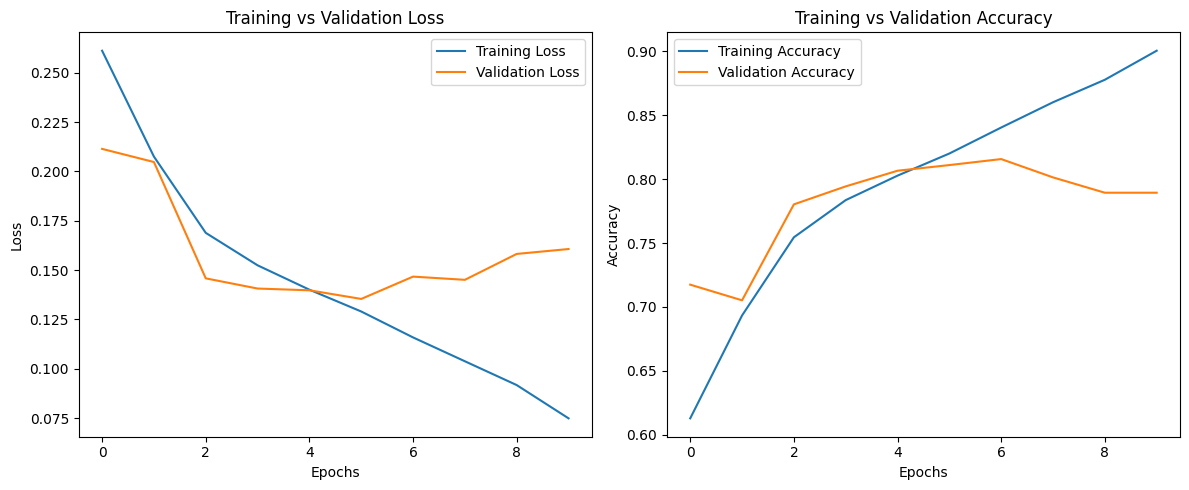

/tmp/ipykernel_31/1557954684.py:300: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_xlmr_linear_model.pth'))



Evaluating model on test set...
Test Accuracy: 0.8000

Confusion Matrix:
[[ 829  403]
 [ 365 2243]]

Classification Report:
              precision    recall  f1-score   support

 Non-Harmful       0.69      0.67      0.68      1232
     Harmful       0.85      0.86      0.85      2608

    accuracy                           0.80      3840
   macro avg       0.77      0.77      0.77      3840
weighted avg       0.80      0.80      0.80      3840



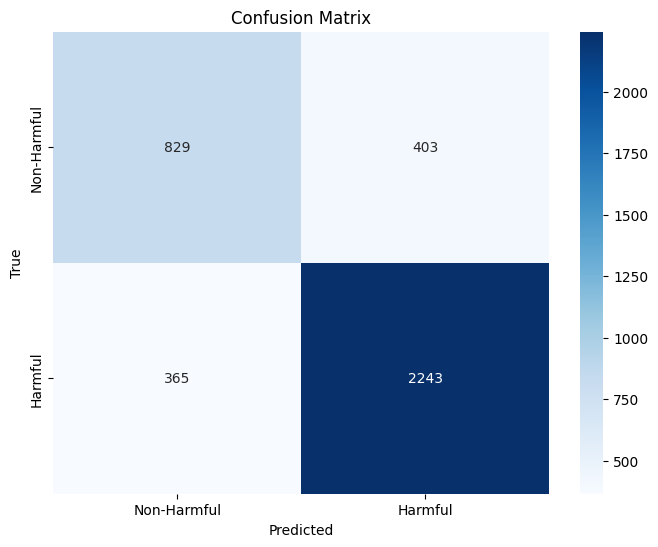

XLM-R linear regression model training and evaluation complete!


In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import XLMRobertaTokenizer, XLMRobertaModel

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
df = pd.read_csv('/kaggle/input/multilingual-meme-datasets/final_datasets.csv')
print(f"Dataset loaded with shape: {df.shape}")

# Custom dataset class for XLM-R
class HarmfulContentTextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        
        # Text features - combine all relevant text fields
        text_features = f"{row['gender']} {row['age']} {row['age_bucket']} {row['dominant_emotion']} {row['dominant_race']} {row['translated_text']}"
        
        # Tokenize text with XLM-R tokenizer
        encoding = self.tokenizer.encode_plus(
            text_features,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,  # XLM-R doesn't use token_type_ids
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(row['label'], dtype=torch.float)  # Changed to float for regression
        }

# Modified model using Linear Regression instead of complex classifier
class XLMRLinearRegressor(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(XLMRLinearRegressor, self).__init__()
        
        # Load pre-trained XLM-R
        self.xlmr = XLMRobertaModel.from_pretrained("xlm-roberta-base")
        
        # Get hidden size from config
        hidden_size = self.xlmr.config.hidden_size  # Typically 768 for base model
        
        # Simple linear regressor - directly map embeddings to a single output
        self.regressor = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, 1)  # Output a single value
        )
        
    def forward(self, input_ids, attention_mask):
        # Process text with XLM-R
        outputs = self.xlmr(input_ids=input_ids, attention_mask=attention_mask)
        
        # Get the [CLS] token embedding (first token)
        embeddings = outputs.last_hidden_state[:, 0, :]
        
        # Regression
        output = self.regressor(embeddings)
        
        return output.squeeze(-1)  # Remove last dimension to match target shape

# Training function modified for regression
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler=None, num_epochs=10):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    
    best_valid_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for batch_idx, batch in enumerate(train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # For accuracy calculation with regression output, use 0.5 as threshold
            predicted = (outputs > 0.5).float()
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
            # Print batch progress
            if (batch_idx + 1) % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}')
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation
        model.eval()
        running_valid_loss = 0.0
        correct_valid = 0
        total_valid = 0
        
        with torch.no_grad():
            for batch in valid_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)
                
                running_valid_loss += loss.item()
                
                # For accuracy calculation with regression output, use 0.5 as threshold
                predicted = (outputs > 0.5).float()
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()
        
        valid_loss = running_valid_loss / len(valid_loader)
        valid_accuracy = correct_valid / total_valid
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}')
        
        # Update scheduler if provided
        if scheduler is not None:
            scheduler.step(valid_loss)
        
        # Save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best_xlmr_linear_model.pth')
            print(f'Saved model with validation loss: {valid_loss:.4f}')
    
    return train_losses, valid_losses, train_accuracies, valid_accuracies

# Function for evaluation and metrics - modified for regression
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predicted = (outputs > 0.5).float()  # Convert to binary using threshold
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    # Convert to integers for classification metrics
    y_true = [int(y) for y in y_true]
    y_pred = [int(y) for y in y_pred]
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred, target_names=['Non-Harmful', 'Harmful'])
    
    print(f'Test Accuracy: {accuracy:.4f}')
    print('\nConfusion Matrix:')
    print(conf_matrix)
    print('\nClassification Report:')
    print(class_report)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Harmful', 'Harmful'], 
                yticklabels=['Non-Harmful', 'Harmful'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('xlmr_linear_confusion_matrix.png')
    plt.show()
    
    return accuracy, conf_matrix, class_report

# Function to plot training curves
def plot_training_curves(train_losses, valid_losses, train_accuracies, valid_accuracies):
    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('xlmr_linear_training_curves.png')
    plt.show()

# Main execution
def main():
    # Initialize tokenizer for XLM-R
    tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
    
    # Split dataset
    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
    valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])
    
    print(f"Train set: {len(train_df)}, Validation set: {len(valid_df)}, Test set: {len(test_df)}")
    
    # Create datasets
    train_dataset = HarmfulContentTextDataset(train_df, tokenizer)
    valid_dataset = HarmfulContentTextDataset(valid_df, tokenizer)
    test_dataset = HarmfulContentTextDataset(test_df, tokenizer)
    
    # Create dataloaders
    batch_size = 32  # Can use larger batch size now that we're only processing text
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)
    
    # Initialize Linear Regression model
    model = XLMRLinearRegressor(dropout_rate=0.3).to(device)
    
    # Use MSE loss for regression
    criterion = nn.MSELoss()
    
    # Create parameter groups with different learning rates
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.xlmr.named_parameters() if not any(nd in n for nd in no_decay)],
         'weight_decay': 0.01, 'lr': 1e-5},  # Lower learning rate for base model
        {'params': [p for n, p in model.xlmr.named_parameters() if any(nd in n for nd in no_decay)],
         'weight_decay': 0.0, 'lr': 1e-5},
        {'params': [p for n, p in model.regressor.named_parameters() if not any(nd in n for nd in no_decay)],
         'weight_decay': 0.01, 'lr': 1e-4},  # Higher learning rate for regressor
        {'params': [p for n, p in model.regressor.named_parameters() if any(nd in n for nd in no_decay)],
         'weight_decay': 0.0, 'lr': 1e-4}
    ]
    
    optimizer = optim.AdamW(optimizer_grouped_parameters)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    
    # Train model
    print("Starting training...")
    train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
        model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=10
    )
    
    # Plot training curves
    plot_training_curves(train_losses, valid_losses, train_accuracies, valid_accuracies)
    
    # Load best model for evaluation
    model.load_state_dict(torch.load('best_xlmr_linear_model.pth'))
    
    # Evaluate model
    print("\nEvaluating model on test set...")
    accuracy, conf_matrix, class_report = evaluate_model(model, test_loader)
    
    # Save final model with metadata
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'accuracy': accuracy,
        'conf_matrix': conf_matrix,
        'class_report': class_report,
    }, 'xlmr_linear_harmful_content_classifier.pth')
    
    print("XLM-R linear regression model training and evaluation complete!")

# Function to analyze dataset
def analyze_dataset(df):
    """
    Analyze the dataset to understand its structure and content.
    """
    print("\n=== Dataset Analysis ===")
    print(f"Dataset shape: {df.shape}")
    print(f"Column names: {df.columns.tolist()}")
    
    # Check label distribution
    print("\nLabel distribution:")
    label_counts = df['label'].value_counts()
    print(label_counts)
    
    # Show sample text entries
    print("\nSample translated_text entries:")
    for i, text in enumerate(df['translated_text'].head(5)):
        print(f"{i+1}: {text[:100]}...")
    
    # Check for missing values
    print("\nMissing values by column:")
    print(df.isnull().sum())
    
    # Analyze text lengths
    df['text_length'] = df['translated_text'].apply(lambda x: len(str(x).split()))
    print("\nText length statistics:")
    print(f"Mean: {df['text_length'].mean():.2f} words")
    print(f"Median: {df['text_length'].median()} words")
    print(f"Min: {df['text_length'].min()} words")
    print(f"Max: {df['text_length'].max()} words")
    
    # Plot text length distribution
    plt.figure(figsize=(10, 6))
    plt.hist(df['text_length'].clip(upper=200), bins=40, alpha=0.7)
    plt.xlabel('Text Length (words)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Text Lengths')
    plt.savefig('text_length_distribution.png')
    plt.show()
    
    return df

if __name__ == "__main__":
    # Analyze the dataset first
    df = analyze_dataset(df)
    # Run the main training procedure
    main()